In [4]:
import torch
import torch.nn.functional as NF

import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

import os
sys.path.append('..')
import sys
from pathlib import Path
from utils.dataset import RealDataset,SyntheticDataset
from utils.ops import *
from utils.path_tracing import ray_intersect,path_tracing

from model.brdf import NGPBRDF
from model.emitter import SLFEmitter

from tqdm import tqdm
import matplotlib.pyplot as plt

## File path

In [10]:
# brdf file
brdf_path = '../checkpoints/kitchen/last.ckpt'
# emission file
emitter_path = '../outputs/kitchen/'

# dataset path
dataset_path = '../data/indoor_synthetic/kitchen'
# dataset type
dataset_type = 'synthetic'

# cuda device
device = torch.device(0)

## Read geometry and model

In [11]:
# load geometry
mesh_file = os.path.join(dataset_path,'scene.obj')
assert Path(mesh_file).exists(), 'mesh file does not exist: '+mesh_file
scene = mitsuba.load_dict({
    'type': 'scene',
    'shape_id':{
        'type': 'obj',
        'filename': mesh_file, 
    }
})

if dataset_type =='synthetic':
    dataset = SyntheticDataset(dataset_path,split='train',pixel=False,ray_diff=True)
elif dataset_type =='real':
    dataset = RealDataset(dataset_path,split='train',pixel=False,ray_diff=True)
img_hw = dataset.img_hw

/home/ruizhu/miniconda3/envs/fipt/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
# load brdf and emitters
mask = torch.load(os.path.join(emitter_path,'vslf.npz'),map_location='cpu')
state_dict = torch.load(brdf_path,map_location='cpu')['state_dict']
weight = {}
for k,v in state_dict.items():
    if 'material.' in k:
        weight[k.replace('material.','')]=v
material_net = NGPBRDF(mask['voxel_min'],mask['voxel_max'])
material_net.load_state_dict(weight)
material_net.to(device)
for p in material_net.parameters():
    p.requires_grad=False
    
emitter_net = SLFEmitter(os.path.join(emitter_path,'emitter.pth'),
                         os.path.join(emitter_path,'vslf.npz'))
emitter_net.to(device)
for p in emitter_net.parameters():
    p.requires_grad = False

## Read BRDF and emission

In [13]:
spp = 128
SPP = 32 # batch size
img_id = 1

In [14]:
# grab some pose
batch = dataset[img_id]
rays = batch['rays'].to(device)
rays_x = rays[...,:3]
rays_d = rays[...,3:6]
dxdu,dydv = rays[...,6:9],rays[...,9:12]

In [15]:
kd = torch.zeros_like(rays_x)
ks = kd.clone()
roughness = torch.zeros_like(rays_x[...,:1])
a_prime = torch.zeros_like(rays_x)
emission = torch.zeros_like(rays_x)

# process in batch to prevent memory issue
for _ in tqdm(range(spp//SPP)):
    # sample pixels
    du,dv = torch.rand(2,len(rays_x),SPP,1,device=device)
    ds = rays_d[:,None]+ dxdu[:,None]*du + dydv[:,None]*dv
    ds = NF.normalize(ds,dim=-1).reshape(-1,3)
    xs = rays_x.repeat_interleave(SPP,dim=0)
    
    positions,normals,_,triagnle_idxs,valid = ray_intersect(scene,xs,ds)
    
    mat = material_net(positions)
    
    # get brdf parameters
    albedo_ = mat['albedo']
    metallic_ = mat['metallic']
    roughness_ = mat['roughness']
    kd_ = albedo_*(1-metallic_)
    ks_ = 0.04*(1-metallic_) + albedo_*metallic_

    # calculate material reflectance
    _,_,g0,g1 = material_net.sample_specular(
        torch.rand(len(metallic_),2,device=device),-ds,normals,roughness_)
    a_prime_ = g0*ks_+g1+kd_
    
    # find emission
    emission_ = emitter_net.eval_emitter(positions,ds,triagnle_idxs)[0]
    emit_mask = emission_.sum(-1,keepdim=True)==0
    valid = valid.unsqueeze(-1)
    
    
    kd += (kd_*valid*emit_mask).reshape(-1,SPP,3).mean(1)
    ks += (ks_*valid*emit_mask).reshape(-1,SPP,3).mean(1)
    a_prime += (a_prime_*valid*emit_mask).reshape(-1,SPP,3).mean(1)
    roughness += (roughness_*valid*emit_mask).reshape(-1,SPP,1).mean(1)
    emission += emission_.reshape(-1,SPP,3).mean(1)
    
kd = kd.reshape(*img_hw,-1).cpu()/(spp//SPP)
ks = ks.reshape(*img_hw,-1).cpu()/(spp//SPP)
roughness = roughness.reshape(*img_hw,-1).cpu()/(spp//SPP)
emission = emission.reshape(*img_hw,-1).cpu()/(spp//SPP)
a_prime = a_prime.reshape(*img_hw,-1).cpu()/(spp//SPP)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


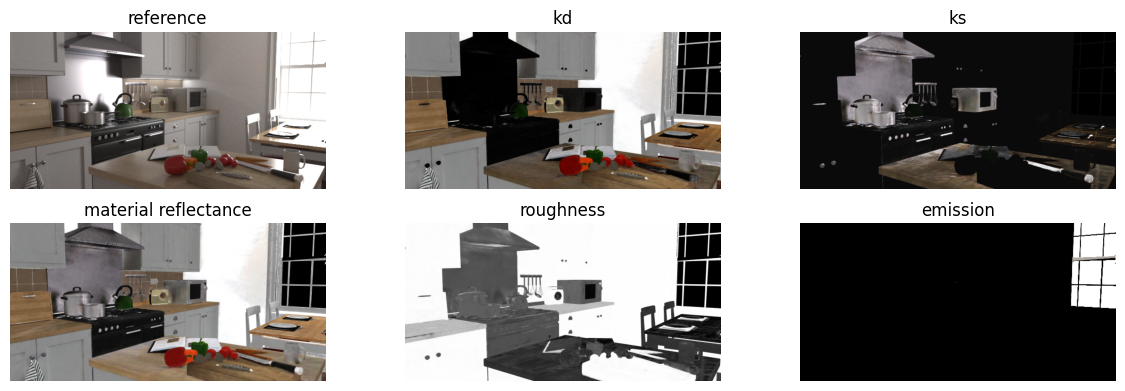

In [16]:
# visualize results
plt.figure(figsize=(12,4))
plt.subplot(2,3,1)
plt.imshow(batch['rgbs'].reshape(*img_hw,3).pow(1/2.2))
plt.title('reference')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(kd.reshape(*img_hw,3))
plt.title('kd')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(ks.reshape(*img_hw,3))
plt.title('ks')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(a_prime.reshape(*img_hw,3))
plt.title('material reflectance')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(roughness.reshape(*img_hw,-1).expand(*img_hw,3))
plt.title('roughness')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(emission.reshape(*img_hw,3).pow(1/2.2))
plt.title('emission')
plt.axis('off')
plt.tight_layout()

# Rendering

In [17]:
spp = 512
SPP = 8 # batch size
indir_depth=7

img_id = 6

In [18]:
# grab some pose
batch = dataset[img_id]
rays = batch['rays'].to(device)
rays_x = rays[...,:3]
rays_d = rays[...,3:6]
dxdu,dydv = rays[...,6:9],rays[...,9:12]

In [19]:
L = torch.zeros_like(rays_x)
# process in batch to prevent memory issue
for _ in tqdm(range(spp//SPP)):
    L += path_tracing(scene,emitter_net,material_net,
                     rays_x,rays_d,
                     dxdu,dydv,
                     SPP,indir_depth=7)
L = L.reshape(*img_hw,-1).cpu()/(spp//SPP)

100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 10.99it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 319.5, -0.5)

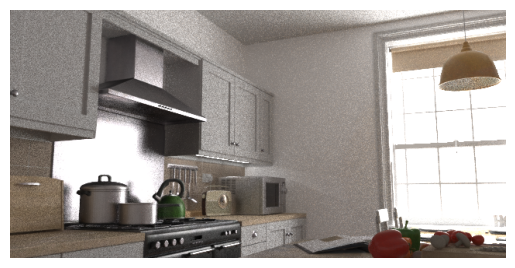

In [20]:
plt.imshow(L.pow(1/2.2))
plt.axis('off')